In [14]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase2 import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [2]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,verbose)
        self.mem = {}
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            if len(self.domain[key]) > 10:
                noChoices = random.randint(1,10)
            else:
                noChoices = random.randint(1,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda summary2,goal: ["
        pos = []
        neg = []
        posMatch = []
        negMatch = []
        notZero = 0
        for gen in chromosome.genes:
            temp2 = []
            temp3 = []
            isZero = True
            for val in gen.value:
                if val != -1:
                    isZero=False
                    temp = f"summary2[{gen.identifier}][{val}][goal] if goal in summary2[{gen.identifier}][{val}] else set()"
                    temp2.append(temp)
                    for goal in self.goals:
                        if goal != -1:
                            temp3.append(f"summary2[{gen.identifier}][{val}][{goal}] if goal != {goal} and {goal} in summary2[{gen.identifier}][{val}] else set()")
            notZero += 1 if not isZero else 0
            pos.append(f"set([]).union(*[{','.join(temp2)}])")
            neg.append(f"set([]).union(*[{','.join(temp3)}])")
        rule += f"[{','.join(pos)}],[{','.join(neg)}],{notZero if notZero > 0 else 100000}"+"]"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        totalPosMatch,totalNegMatch,noChromosomes = matchProportion(self.summarized2,goal)
        countPosMatch = 0
        for row in totalPosMatch:
            for col in row:
                countPosMatch += self.matrix[col][1]
        countPosMatch = countPosMatch / noChromosomes
        countNegMatch = 0
        for row in totalNegMatch:
            for col in row:
                countNegMatch += self.matrix[col][1]
        countNegMatch = countNegMatch / noChromosomes
        totalPos = self.summarized["total"][goal]
        totalNeg = self.summarized["total"]["total"]-self.summarized["total"][goal]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples) 
        negProp = (totalNeg/totalExamples) 
        total = (countPosMatch * negProp) + (-1*countNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        res = total/maxTotal
        return res
    
    def regulation(self,population):
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = [x for x in range(1,len(population.chromosomes))]
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 1
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .5
        self.noChromosomes = 3
        self.noIterations = 10
        super().setup()

In [3]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatchDynamic = 0
        totalMatchStatic = 0
        totalStatic = 0
        totalDynamic = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatchDynamic += (cell0 != cell1 and cell1 == cell2)
            totalMatchStatic += (cell0 == cell1 and cell1 == cell2)
            totalStatic += (cell0 == cell1)
            totalDynamic += (cell0 != cell1)
        totalStatic = totalStatic if totalStatic > 0 else 0
        totalDynamic = totalDynamic if totalDynamic > 0 else 0
        return [totalStatic,totalDynamic,totalMatchStatic,totalMatchDynamic]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: 
                    print(f"Static : {summation[2]}/{summation[0]}")
                    print(f"Dynamic : {summation[3]}/{summation[1]}")
                totalStatic = summation[2]/summation[0] if summation[0] > 0 else 0
                totalDynamic = summation[3]/summation[1] if summation[1] > 0 else 0
                res.append([totalStatic,totalDynamic])
        self.result = np.array(res)
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result[:,0])
        plt.plot(range(len(self.result)),self.result[:,1])
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

In [4]:
data  = np.load("data/data_gray.npy")
dataSplit = {}
#plt.matshow(data[2,50:100,50:250])
block = 50
x = 0
y = 0
size = np.shape(data)
for i in range(size[1]//block):
    for j in range(size[2]//block):
        dataSplit[f"{i},{j}"] = (data[:,x:x+block,y:y+block])
        y += block
    x += block
np.shape(dataSplit["0,0"])

(708, 50, 50)

In [5]:
data  = dataSplit["0,0"]#np.load("data/data_gray.npy")
#data = data[:,50:100,50:250]
print(np.shape(data))
train = math.floor(len(data) * 0.8)
print(np.shape(data[:train]))
exp2 = Experiment1(data[:train],"Experiment8","experiment8",verbose=2)
exp2.run()

(708, 50, 50)
(566, 50, 50)
start setup
Start 1 (50, 50)Start 2 (50, 50)Start 3 (50, 50)

Start 4 (50, 50)

middle 2.682111978530884
End 2 2.706757068634033
Start 5 (50, 50)
middle 2.744503974914551
End 1 2.7654597759246826
Start 6 (50, 50)
middle 2.7777581214904785
End 3 2.799604892730713
Start 7 (50, 50)
middle 2.8274688720703125
End 4 2.8568830490112305
Start 8 (50, 50)
middle 1.8797581195831299
End 5 1.9033300876617432
Start 9 (50, 50)
middle 1.8586649894714355
End 6 1.8802978992462158
Start 10 (50, 50)
middle 1.8902652263641357
End 7 1.9104700088500977
Start 11 (50, 50)
middle 1.8893029689788818
End 8 1.909872055053711
Start 12 (50, 50)
middle 1.7729229927062988middle 1.8048620223999023

End 10 1.809546947479248End 9 1.8459348678588867
Start 13 (50, 50)middle 1.691410779953003


Start 14 (50, 50)
End 12 1.7144889831542969middle 1.7780406475067139

Start 15 (50, 50)
End 11 1.8049919605255127
Start 16 (50, 50)
middle 1.7013072967529297
End 13 1.7244291305541992
middle 1.670034170150

In [15]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [19]:
prediction = []
for it in model.run(data[0],50):
    prediction.append(it[1])

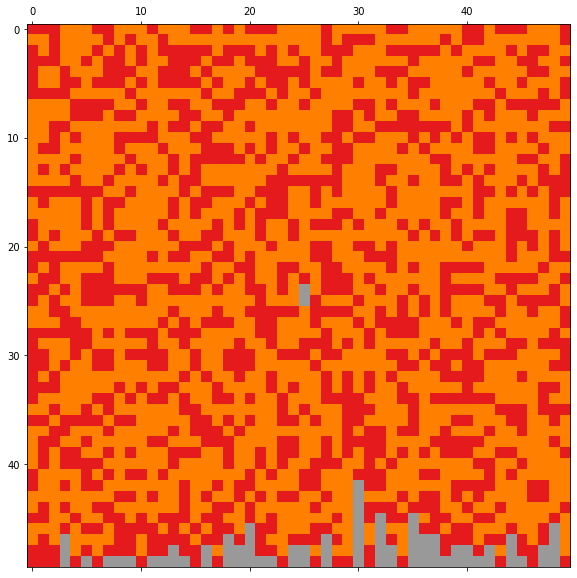

In [20]:
helpers.animate(prediction)

Testing:
state 1/708
Static : 2499/2499
Dynamic : 0/1
state 2/708
Static : 2499/2499
Dynamic : 0/1
state 3/708
Static : 2499/2499
Dynamic : 0/1
state 4/708
Static : 2500/2500
Dynamic : 0/0
state 5/708
Static : 2499/2499
Dynamic : 0/1
state 6/708
Static : 2500/2500
Dynamic : 0/0
state 7/708
Static : 2500/2500
Dynamic : 0/0
state 8/708
Static : 2500/2500
Dynamic : 0/0
state 9/708
Static : 2500/2500
Dynamic : 0/0
state 10/708
Static : 2497/2497
Dynamic : 0/3
state 11/708
Static : 2497/2497
Dynamic : 0/3
state 12/708
Static : 2499/2499
Dynamic : 0/1
state 13/708
Static : 2500/2500
Dynamic : 0/0
state 14/708
Static : 2500/2500
Dynamic : 0/0
state 15/708
Static : 2499/2499
Dynamic : 0/1
state 16/708
Static : 2500/2500
Dynamic : 0/0
state 17/708
Static : 2500/2500
Dynamic : 0/0
state 18/708
Static : 2500/2500
Dynamic : 0/0
state 19/708
Static : 2500/2500
Dynamic : 0/0
state 20/708
Static : 2500/2500
Dynamic : 0/0
state 21/708
Static : 2500/2500
Dynamic : 0/0
state 22/708
Static : 2500/2500
Dy

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

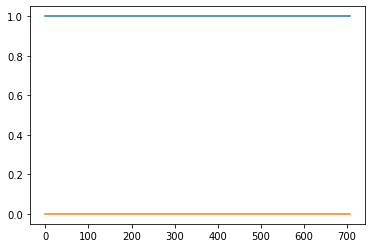

In [17]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

In [6]:
visualization = Visualization("experiment8/15_01_20_11_38_44")

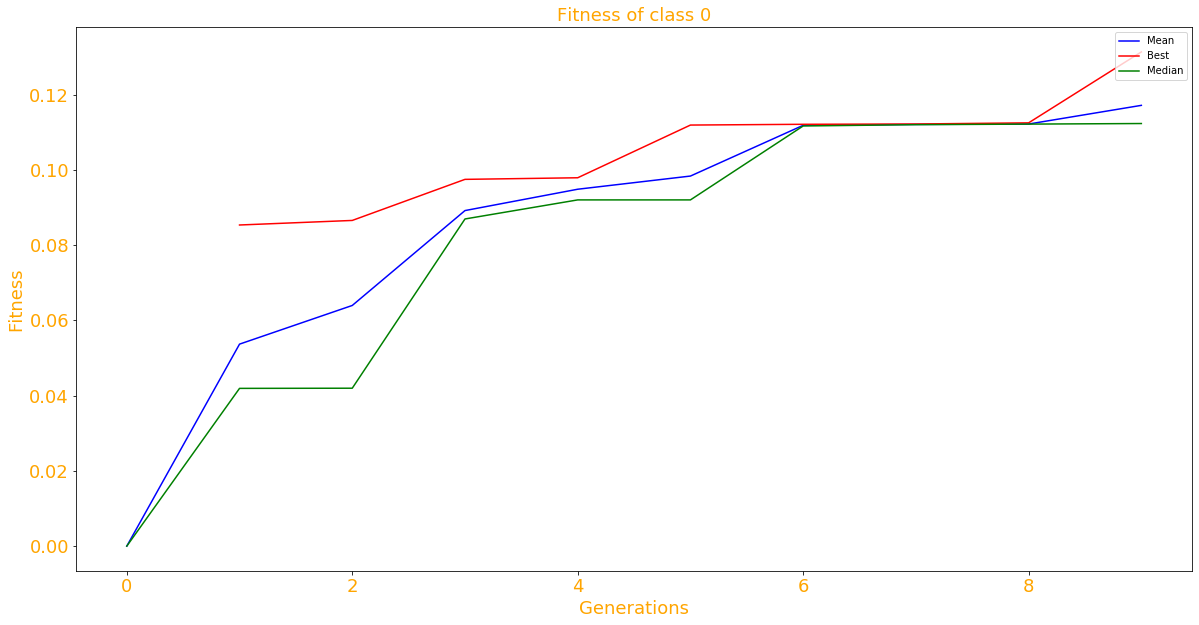

In [7]:
visualization.getFitnessGraph("0")

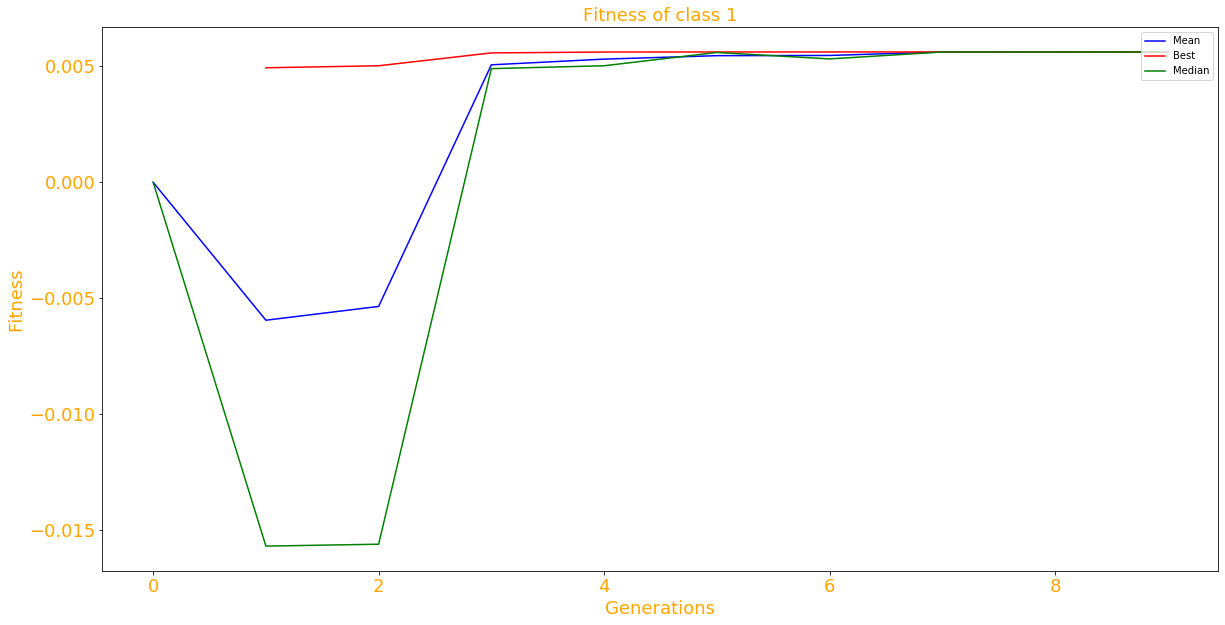

In [8]:
visualization.getFitnessGraph("1")

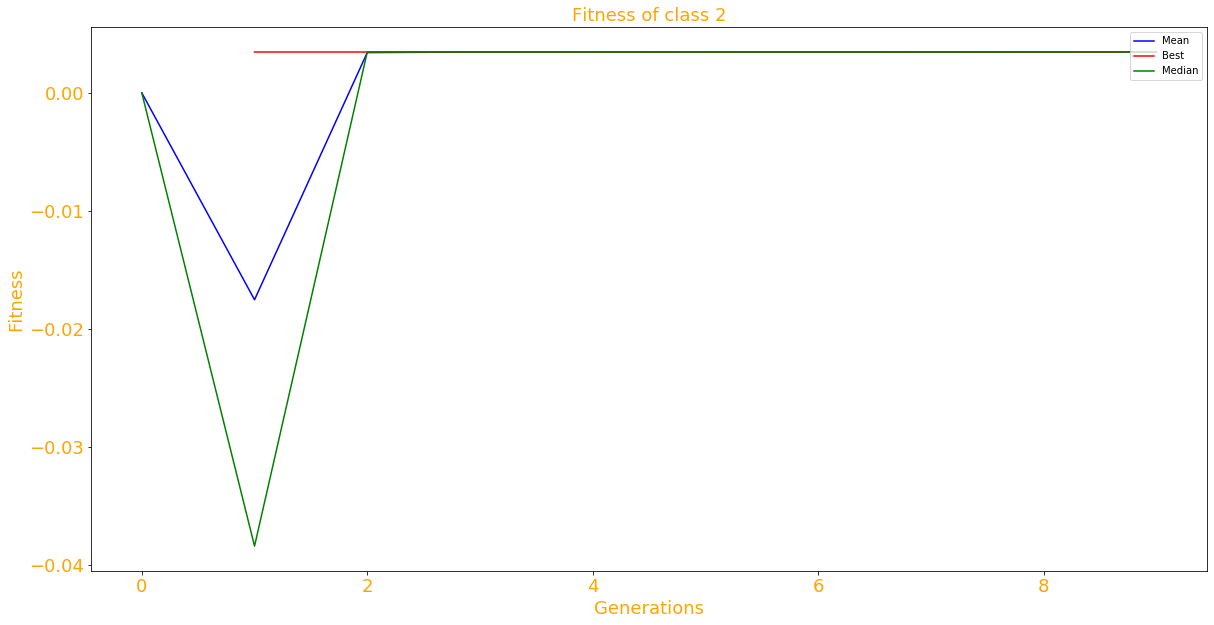

In [9]:
visualization.getFitnessGraph("2")

In [16]:
transformer.lmstr

{0: 'lambda x: (x[0] in {32, 130, 69, 39, 79, 180, 89, 186, 123} if x[0] != -1 else True) and (x[3] in {0, 2, 146, 75, 76} if x[3] != -1 else True) and (x[4] in {84, 71} if x[4] != -1 else True) and (x[5] in {91, 100} if x[5] != -1 else True) and (x[6] in {0, 35, 9, 45, 46, 78, 81, 115, 25} if x[6] != -1 else True) and (x[7] in {197, 59, 106, 77, 113, 242, 147, 24, 91} if x[7] != -1 else True)',
 1: 'lambda x: (x[0] in {3, 147, 73, 107, 46} if x[0] != -1 else True) and (x[2] in {112, 4, 229, 212, 200, 120, 205} if x[2] != -1 else True) and (x[3] in {99, 36, 138, 28, 87, 121, 26, 92} if x[3] != -1 else True) and (x[4] in {184, 35} if x[4] != -1 else True) and (x[5] in {75, 134} if x[5] != -1 else True) and (x[6] in {67, 69, 39, 73, 140, 108, 44, 57} if x[6] != -1 else True) and (x[7] in {128, 32, 64, 227, 100, 203} if x[7] != -1 else True) and (x[8] in {99, 36, 26, 81, 117, 183, 186, 124} if x[8] != -1 else True)',
 2: 'lambda x: (x[0] in {33, 116, 85, 134, 54, 57, 157} if x[0] != -1 el

In [62]:
exp2.world.toDict()

{'generation': 99,
 'populations': [{'generation': 99,
   'goal': '0',
   'chromosomes': [{'uuid': '69864558-f3a0-41fa-b837-91d64974b952',
     'generation': 95,
     'genes': [{'identifier': '0', 'value': 'set()'},
      {'identifier': '1', 'value': 'set()'},
      {'identifier': '2', 'value': 'set()'},
      {'identifier': '3', 'value': '{-1}'},
      {'identifier': '4', 'value': 'set()'},
      {'identifier': '5', 'value': 'set()'},
      {'identifier': '6', 'value': 'set()'},
      {'identifier': '7', 'value': 'set()'},
      {'identifier': '8', 'value': 'set()'},
      {'identifier': '9', 'value': '{0, 2}'},
      {'identifier': '10', 'value': 'set()'},
      {'identifier': '11', 'value': 'set()'},
      {'identifier': '12', 'value': '{0}'},
      {'identifier': '13', 'value': '{-1}'},
      {'identifier': '14', 'value': 'set()'},
      {'identifier': '15', 'value': 'set()'},
      {'identifier': '16', 'value': '{-1}'},
      {'identifier': '17', 'value': '{-1}'},
      {'identifi

In [13]:
import sys
del sys.modules["ExperimentBase2"]